In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
label_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\custom'
image_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\image\official'

In [7]:
def create_centerness_box(H,W):
    hor_L,ver_L = W,H
    
    hor = np.arange(0,hor_L)
    hor_min = np.fmin(hor,hor[::-1])
    hor_max = hor_L-1-hor_min
    hor_cen = hor_min/hor_max
    
    ver = np.arange(0,ver_L)
    ver_min = np.fmin(ver,ver[::-1])
    ver_max = ver_L-1-ver_min
    ver_cen = ver_min/ver_max
    ver_cen = ver_cen[:,None]

    centerness = np.sqrt(hor_cen * ver_cen)
    return centerness

In [20]:
create_centerness_box(6,6)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.25      , 0.40824829, 0.40824829, 0.25      ,
        0.        ],
       [0.        , 0.40824829, 0.66666667, 0.66666667, 0.40824829,
        0.        ],
       [0.        , 0.40824829, 0.66666667, 0.66666667, 0.40824829,
        0.        ],
       [0.        , 0.25      , 0.40824829, 0.40824829, 0.25      ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

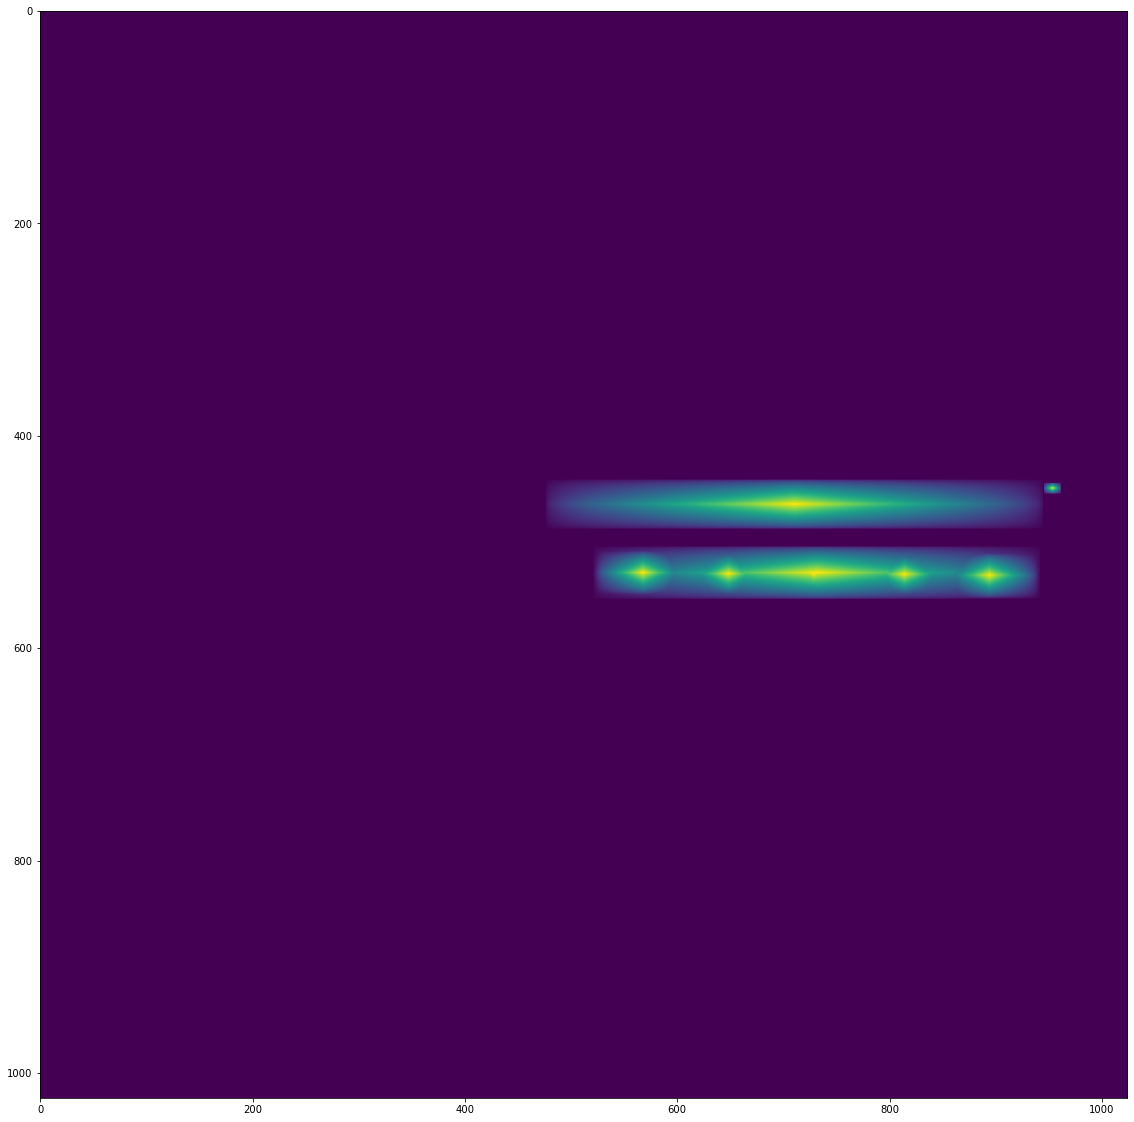

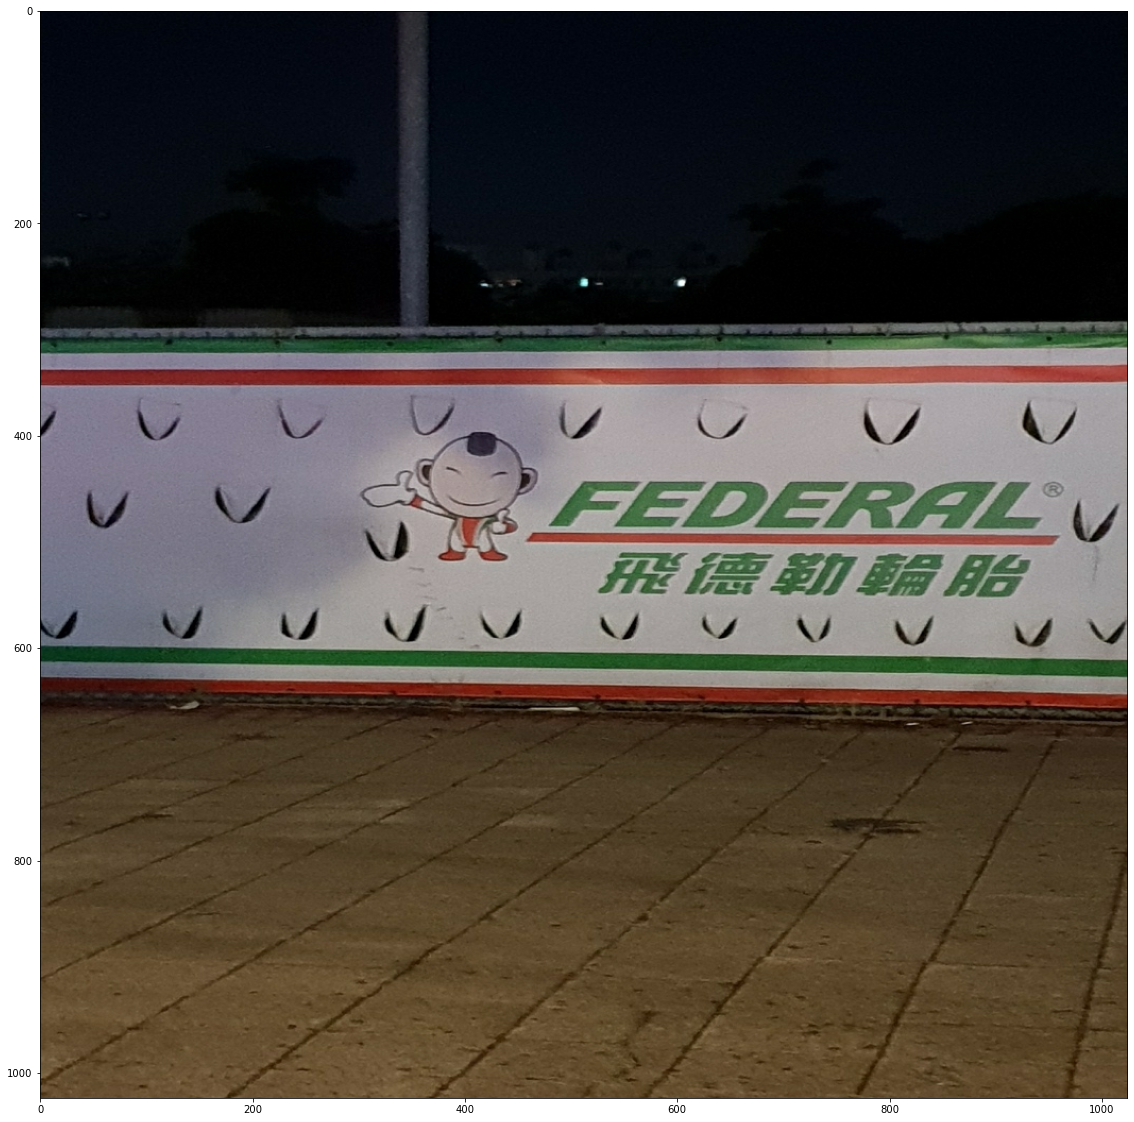

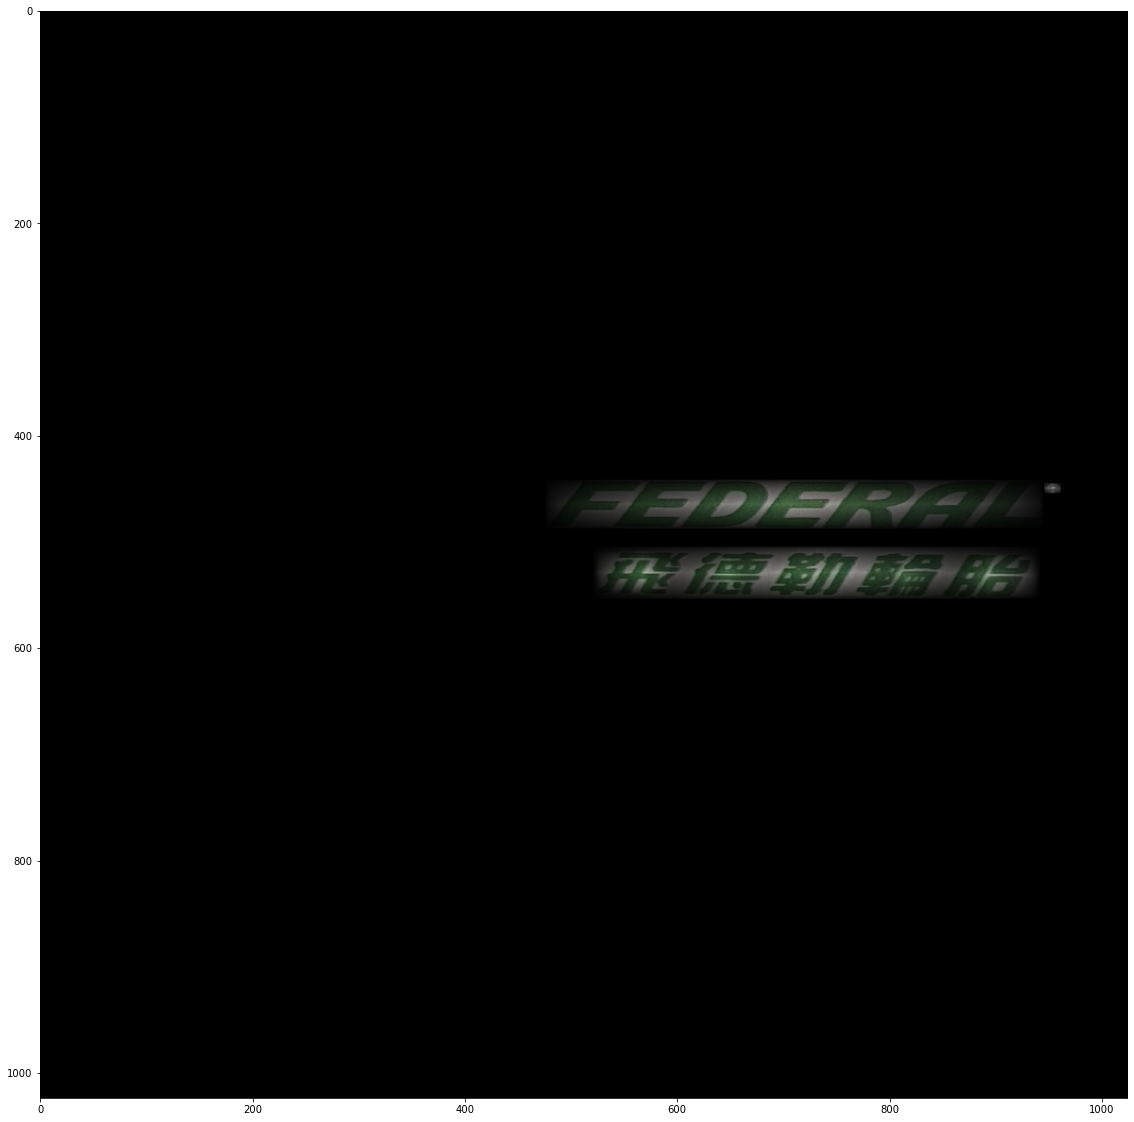

In [30]:
label_path = list(pathlib.Path(label_folder).iterdir())
label = json.loads(label_path[5856].read_text(encoding='utf8'))
image_byte = tf.io.read_file(pathlib.Path(image_folder,label['ImageName']).as_posix())
image = tf.image.decode_jpeg(image_byte)
image = tf.image.convert_image_dtype(image,tf.float32)
image = tf.image.resize(image,(1024,1024))

ltwh = np.array([b['rectangle']['ltwh'] for b in label['bboxes']])
ltwh = (ltwh*1024).astype(int)
object_maps = []
for l,t,w,h in ltwh:
    object_map = np.zeros((1024,1024))
    object_map[t:t+h,l:l+w] = create_centerness_box(h,w)
    object_maps.append(object_map)
object_maps = np.stack(object_maps,axis=-1)
object_maps = np.max(object_maps,axis=-1)

plt.figure(figsize=(20,20))
plt.imshow(object_maps)
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(image*object_maps[:,:,None])
plt.show()